In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
tr_data = pd.read_csv('../input/train.csv')
te_data = pd.read_csv('../input/test.csv')
print('train shape is: {} \r\ntest shape is: {} '.format(tr_data.shape,te_data.shape))

train shape is: (61878, 95) 
test shape is: (144368, 94) 


In [3]:
from sklearn.feature_extraction.text import TfidfTransformer

y = tr_data.target
tr_ids = tr_data.id
te_ids = te_data.id
tr_data.drop(['id','target'],axis=1,inplace=True)
te_data.drop(['id'],axis=1,inplace=True)

In [4]:
tr_data['count_zeros'] = (tr_data == 0).astype(int).sum(axis=1)
te_data['count_zeros'] = (te_data == 0).astype(int).sum(axis=1)

tr_data['num_greater_than_3'] = (tr_data > 3).astype(int).sum(axis=1)
te_data['num_greater_than_3'] = (te_data > 3).astype(int).sum(axis=1)

tr_data['num_greater_than_10'] = (tr_data > 10).astype(int).sum(axis=1)
te_data['num_greater_than_10'] = (te_data > 10).astype(int).sum(axis=1)

In [5]:
tfidf = TfidfTransformer()
tr_data_tfidf = pd.DataFrame(tfidf.fit_transform(tr_data).toarray())
te_data_tfidf = pd.DataFrame(tfidf.transform(te_data).toarray())
tr_data_tfidf.columns = [str(x)+'tfidf' for x in tr_data_tfidf.columns]
te_data_tfidf.columns = [str(x)+'tfidf' for x in te_data_tfidf.columns]

tr_data_log1p = pd.DataFrame(tr_data.apply(lambda x: np.log1p(x)))
te_data_log1p = pd.DataFrame(te_data.apply(lambda x: np.log1p(x)))
tr_data_log1p.columns = [str(x)+'log1p' for x in tr_data_log1p.columns]
te_data_log1p.columns = [str(x)+'log1p' for x in te_data_log1p.columns]

tr_data_comb = pd.concat([tr_data,tr_data_tfidf,tr_data_log1p],axis=1)
te_data_comb = pd.concat([te_data,te_data_tfidf,te_data_log1p],axis=1)

In [6]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)
y_encoded = [int(x.split('_')[1]) for x in y]
y_encoded = [y-1 for y in y_encoded]

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.model_selection import train_test_split,KFold

X_train, X_val, y_train, y_val = train_test_split(tr_data_comb,y_encoded,test_size = 0.2,random_state =12345)

In [9]:
import xgboost as xgb

params = {'objective':'multi:softprob',
                    'learning_rate':0.1,
                    'subsample':0.8,
                    'colsample_bytree':0.9,
                    'colsample_bylevel':0.7,
                    'max_depth':7,
                    'nthread':4,
                    'eval_metric':'mlogloss',
                    'num_class':9,
                    'gamma':0.1,
                    'seed':1234}

bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(tr_data_comb,label=y_encoded),verbose_eval=2,
                nfold=5,early_stopping_rounds=20,num_boost_round=30)
#try 400 boosting rounds

[0]	train-mlogloss:1.9474+0.00072084	test-mlogloss:1.955+0.000620196
[2]	train-mlogloss:1.62157+0.000899508	test-mlogloss:1.641+0.00145632
[4]	train-mlogloss:1.40371+0.0012475	test-mlogloss:1.43284+0.00202743
[6]	train-mlogloss:1.24356+0.00175519	test-mlogloss:1.28098+0.00266732
[8]	train-mlogloss:1.11843+0.00158386	test-mlogloss:1.16309+0.00315141
[10]	train-mlogloss:1.01842+0.0016977	test-mlogloss:1.06957+0.00338205
[12]	train-mlogloss:0.936599+0.0017721	test-mlogloss:0.993884+0.0036907
[14]	train-mlogloss:0.868352+0.00185664	test-mlogloss:0.931137+0.00362796
[16]	train-mlogloss:0.811162+0.00168662	test-mlogloss:0.87921+0.00341374
[18]	train-mlogloss:0.761766+0.00178435	test-mlogloss:0.835099+0.00350619
[20]	train-mlogloss:0.719773+0.00195614	test-mlogloss:0.798319+0.00367584
[22]	train-mlogloss:0.682774+0.00211222	test-mlogloss:0.766007+0.00364953
[24]	train-mlogloss:0.650396+0.0019471	test-mlogloss:0.738084+0.00364314
[26]	train-mlogloss:0.622625+0.00185526	test-mlogloss:0.714523+0

In [10]:
#bst = xgb.train(params=params,dtrain=xgb.DMatrix(tr_data_comb,label=y_encoded),num_boost_round=400)

In [97]:
pred = bst.predict(xgb.DMatrix(te_data_comb))
subm = pd.DataFrame(pred)
subm.columns = ['class_'+ str(x) for x in range(1,10)]
subm['id'] = pd.read_csv('../input/test.csv',usecols=['id'])
#subm.index_label = 'id'
subm.to_csv('../subm/tfidf_log1p_raw_xgb_sub1.csv',index=False)

#### let's ignore the tfidf transform for and see what you could also come up with based on the things we learned...

In [113]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(tr_data,y_encoded,test_size = 0.2,random_state =12345)

knn2 = KNeighborsClassifier(n_jobs=4,n_neighbors=2,)
knn2.fit(X_train,y_train)
knn2_pred = knn2.predict_proba(X_val)
print('log loss for knn2: {}'.format(log_loss(y_pred = knn2_pred,y_true = y_val)))

knn4 = KNeighborsClassifier(n_jobs=4,n_neighbors=4,)
knn4.fit(X_train,y_train)
knn4_pred = knn4.predict_proba(X_val)
print('log loss for knn4: {}'.format(log_loss(y_pred = knn4_pred,y_true = y_val)))

knn8 = KNeighborsClassifier(n_jobs=8,n_neighbors=8,)
knn8.fit(X_train,y_train)
knn8_pred = knn8.predict_proba(X_val)
print('log loss for knn8: {}'.format(log_loss(y_pred = knn8_pred,y_true = y_val)))

knn16 = KNeighborsClassifier(n_jobs=4,n_neighbors=16,)
knn16.fit(X_train,y_train)
knn16_pred = knn16.predict_proba(X_val)
print('log loss for knn16: {}'.format(log_loss(y_pred = knn16_pred,y_true = y_val)))

knn32 = KNeighborsClassifier(n_jobs=4,n_neighbors=32,)
knn32.fit(X_train,y_train)
knn32_pred = knn32.predict_proba(X_val)
print('log loss for knn32: {}'.format(log_loss(y_pred = knn32_pred,y_true = y_val)))

knn64 = KNeighborsClassifier(n_jobs=4,n_neighbors=64,)
knn64.fit(X_train,y_train)
knn64_pred = knn64.predict_proba(X_val)
print('log loss for knn64: {}'.format(log_loss(y_pred = knn64_pred,y_true = y_val)))

knn128 = KNeighborsClassifier(n_jobs=4,n_neighbors=128,)
knn128.fit(X_train,y_train)
knn128_pred = knn128.predict_proba(X_val)
print('log loss for knn128: {}'.format(log_loss(y_pred = knn128_pred,y_true = y_val)))

log loss for knn2: 4.8441469936134425
log loss for knn4: 2.6644552310076475
log loss for knn8: 1.5318682781966835
log loss for knn16: 0.9965564078189585
log loss for knn32: 0.7943305611598044
log loss for knn64: 0.7002169581175647
log loss for knn128: 0.6943451757833374


In [101]:
class_weights = {0:1,1:1,2:1,3:10,4:1,5:1,6:1,7:1,8:1}
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(class_weight=class_weights,max_depth=4,max_features=92,min_samples_split=2,random_state=12345)
dtc.fit(X_train,y_train)
tree_pred = dtc.predict_proba(X_val)
print('log loss for dtc: {}'.format(log_loss(y_pred = tree_pred,y_true = y_val)))

log loss for dtc: 1.647334289958738


In [102]:
# class_weights = {0:1,1:1,2:1,3:1,4:1,5:1,6:10,7:1,8:1}
# lets remove the class weights and check our score...
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=4,max_features=92,min_samples_split=2,random_state=12345)
dtc.fit(X_train,y_train)
tree_pred = dtc.predict_proba(X_val)
print('log loss for dtc: {}'.format(log_loss(y_pred = tree_pred,y_true = y_val)))

log loss for dtc: 1.4348667288258288


In [114]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',C=0.1,max_iter=10000,random_state=12345,probability=True)
svc.fit(X_train,y_train)
svc_pred = svc.predict_proba(X_val)
print('log loss for svc: {}'.format(log_loss(y_pred = svc_pred,y_true = y_val)))

/home/nati/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


log loss for svc: 0.6653540066424208


In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',C=0.1,max_iter=10000,random_state=12345,probability=True,)
svc.fit(X_train,y_train)
svc_pred = svc.predict_proba(X_val)
print('log loss for svc: {}'.format(log_loss(y_pred = svc_pred,y_true = y_val)))

In [109]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=4,n_estimators=300)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict_proba(X_val)
print('log loss for RFC: {}'.format(log_loss(y_pred = rfc_pred,y_true = y_val)))

log loss for RFC: 0.5726116665922214


In [61]:
rfc_test_pred = rfc.predict_proba(te_data)

In [92]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,label=y_train)
dval=xgb.DMatrix(X_val,label=y_val)
watchlist = [(dtrain, 'train'),(dval, 'eval')]

params = {'objective':'multi:softprob',
                    'learning_rate':0.05,
                    'subsample':0.7,
                    'colsample_bytree':0.8,
                    'colsample_bylevel':0.7,
                    'max_depth':6,
                    'nthread':3,
                    'eval_metric':'mlogloss',
                    'num_class':9,
                    'silent':0,
                    'seed':1234}

bst = xgb.train(params=params,dtrain=xgb.DMatrix(X_train,label=y_train),num_boost_round=3000,early_stopping_rounds=80,
                evals=watchlist,verbose_eval=50)

[0]	eval-mlogloss:2.0774	train-mlogloss:2.075
Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.

Will train until train-mlogloss hasn't improved in 80 rounds.
[50]	eval-mlogloss:0.765823	train-mlogloss:0.704729
[100]	eval-mlogloss:0.605446	train-mlogloss:0.512647
[150]	eval-mlogloss:0.553927	train-mlogloss:0.438171
[200]	eval-mlogloss:0.528086	train-mlogloss:0.392941
[250]	eval-mlogloss:0.512905	train-mlogloss:0.359338
[300]	eval-mlogloss:0.50243	train-mlogloss:0.332146
[350]	eval-mlogloss:0.49479	train-mlogloss:0.309143
[400]	eval-mlogloss:0.48858	train-mlogloss:0.288172
[450]	eval-mlogloss:0.484047	train-mlogloss:0.27052
[500]	eval-mlogloss:0.480213	train-mlogloss:0.25378
[550]	eval-mlogloss:0.477109	train-mlogloss:0.238802
[600]	eval-mlogloss:0.474876	train-mlogloss:0.225237
[650]	eval-mlogloss:0.473521	train-mlogloss:0.212742
[700]	eval-mlogloss:0.472207	train-mlogloss:0.200934
[750]	eval-mlogloss:0.471159	train-mlogloss:0.189759
[800]	eval-m

KeyboardInterrupt: 

In [111]:
xgb_pred = bst.predict(xgb.DMatrix(X_val))
print('log loss for XGB: {}'.format(log_loss(y_pred = xgb_pred,y_true = y_val)))

log loss for XGB: 0.46402587516456023


In [62]:
xgb_test_pred = bst.predict(xgb.DMatrix(te_data))
combined_pred = xgb_test_pred *0.85 + rfc_test_pred *0.15
subm = pd.DataFrame(combined_pred)
subm.columns = ['class_'+ str(x) for x in range(1,10)]
subm['id'] = pd.read_csv('../input/test.csv',usecols=['id'])
#subm.index_label = 'id'
subm.to_csv('../subm/rf_xgb_sub1.csv',index=False)

In [11]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Merge,Embedding,BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam

OHE_y_train = np_utils.to_categorical(y_train)
OHE_y_val = np_utils.to_categorical(y_val)


In [13]:
from keras.callbacks import ReduceLROnPlateau
cb = ReduceLROnPlateau(patience=0,factor=0.1,epsilon=0.02)

In [28]:
model1 = Sequential()
model1.add(Dense(500,input_shape=(X_train.shape[1],),activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(250,activation='relu'))
model1.add(Dropout(0.05))
model1.add(Dense(50,activation='relu'))
model1.add(Dense(9,activation='softmax'))
model1.compile(optimizer='adam',
              loss='categorical_crossentropy')

model1.fit(X_train.values,OHE_y_train,validation_data=[X_val.values,OHE_y_val],callbacks=[cb],epochs=10)

Train on 49502 samples, validate on 12376 samples
Epoch 1/10
49502/49502 [==============================] - 13s - loss: 0.7291 - val_loss: 0.5988
Epoch 2/10
49502/49502 [==============================] - 12s - loss: 0.5849 - val_loss: 0.5516
Epoch 3/10
49502/49502 [==============================] - 12s - loss: 0.5515 - val_loss: 0.5489
Epoch 4/10
49502/49502 [==============================] - 13s - loss: 0.5268 - val_loss: 0.5249
Epoch 5/10
49502/49502 [==============================] - 13s - loss: 0.5021 - val_loss: 0.4952
Epoch 6/10
49502/49502 [==============================] - 12s - loss: 0.4830 - val_loss: 0.5169
Epoch 7/10
49502/49502 [==============================] - 13s - loss: 0.4676 - val_loss: 0.5033
Epoch 8/10
49502/49502 [==============================] - 13s - loss: 0.4069 - val_loss: 0.4754
Epoch 9/10
49502/49502 [==============================] - 12s - loss: 0.3882 - val_loss: 0.4738
Epoch 10/10
49502/49502 [==============================] - 13s - loss: 0.3869 - val_lo

12128/12376 [============================>.] - ETA: 0s[[ 225   11    1    0    1   26   13   41   92]
 [   2 2630  489   53    5    5   19   11    8]
 [   0  638  832   36    1    1   32    9    1]
 [   1  154   96  268    7   14   14    3    0]
 [   1    8    2    0  523    0    0    1    0]
 [  13   10    3    6    0 2699   34   25   20]
 [   8   46   41    5    0   27  392   17    2]
 [  20   10    3    0    2   37   21 1575   27]
 [  35   16    2    3    0   27    3   31  942]]
classification report results:
             precision    recall  f1-score   support

          0       0.74      0.55      0.63       410
          1       0.75      0.82      0.78      3222
          2       0.57      0.54      0.55      1550
          3       0.72      0.48      0.58       557
          4       0.97      0.98      0.97       535
          5       0.95      0.96      0.96      2810
          6       0.74      0.73      0.74       538
          7       0.92      0.93      0.92      1695
    

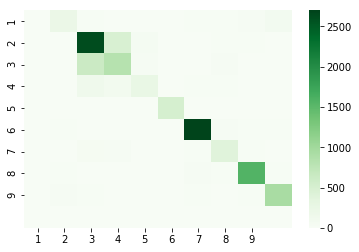

In [29]:
ann_pred = model1.predict_classes(X_val.values)
from sklearn.metrics import classification_report,log_loss
print(confusion_matrix(y_pred=ann_pred,y_true=y_val))
sns.heatmap(confusion_matrix(y_pred=ann_pred+1,y_true=y_val),cmap='Greens',xticklabels=range(1,10),yticklabels=range(1,10))
print('classification report results:\r\n' + classification_report(y_pred=ann_pred,y_true=y_val))
print('log-loss for classifier: {}'.format(log_loss(y_pred=model1.predict(X_val.values),y_true=y_val)))

In [30]:
model1 = Sequential()
model1.add(Dense(500,input_shape=(X_train.shape[1],),activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(250,activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(50,activation='relu'))
model1.add(Dense(9,activation='softmax'))
model1.compile(optimizer='adam',
              loss='categorical_crossentropy')

model1.fit(X_train.values,OHE_y_train,validation_data=[X_val.values,OHE_y_val],callbacks=[cb],epochs=10)

Train on 49502 samples, validate on 12376 samples
Epoch 1/10
49502/49502 [==============================] - 13s - loss: 0.7567 - val_loss: 0.5862
Epoch 2/10
49502/49502 [==============================] - 12s - loss: 0.6026 - val_loss: 0.5620
Epoch 3/10
49502/49502 [==============================] - 12s - loss: 0.5685 - val_loss: 0.5448
Epoch 4/10
49502/49502 [==============================] - 12s - loss: 0.5448 - val_loss: 0.5256
Epoch 5/10
49502/49502 [==============================] - 12s - loss: 0.5254 - val_loss: 0.5223
Epoch 6/10
49502/49502 [==============================] - 12s - loss: 0.5086 - val_loss: 0.5086
Epoch 7/10
49502/49502 [==============================] - 12s - loss: 0.4541 - val_loss: 0.4772
Epoch 8/10
49502/49502 [==============================] - 12s - loss: 0.4406 - val_loss: 0.4725
Epoch 9/10
49502/49502 [==============================] - 12s - loss: 0.4309 - val_loss: 0.4717
Epoch 10/10
49502/49502 [==============================] - 12s - loss: 0.4220 - val_lo

In [16]:
oof_preds = []
test_preds = []
kf = KFold(n_splits=5,shuffle=True,random_state=12345)
for train_index, val_index in kf.split(X=tr_data_comb,y=y_encoded):
    #print(train_index,val_index)
    X_train, X_val = tr_data_comb.iloc[train_index,:], tr_data_comb.iloc[val_index,:]
    y_train, y_val = np.array(y_encoded)[train_index], np.array(y_encoded)[val_index]
    OHE_y_train = np_utils.to_categorical(y_train)
    OHE_y_val = np_utils.to_categorical(y_val)
    
    model1 = Sequential()
    model1.add(Dense(1500,input_shape=(X_train.shape[1],),activation='relu'))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.3))
    model1.add(Dense(500,activation='relu'))
    model1.add(Dropout(0.1))
    model1.add(Dense(250,activation='relu'))
    model1.add(Dense(9,activation='softmax'))
    model1.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy')

    model1.fit(X_train.values,OHE_y_train,validation_data=[X_val.values,OHE_y_val],callbacks=[cb],epochs=10)
    
    ann_pred = model1.predict(X_val.values)
    ann_test_pred = model1.predict(te_data_comb.values)
    oof_preds.append(ann_pred)
    test_preds.append(ann_test_pred)
    

Train on 49502 samples, validate on 12376 samples
Epoch 1/10
49502/49502 [==============================] - 17s - loss: 0.7046 - val_loss: 0.6144
Epoch 2/10
49502/49502 [==============================] - 17s - loss: 0.6118 - val_loss: 0.5676
Epoch 3/10
49502/49502 [==============================] - 17s - loss: 0.5856 - val_loss: 0.5570
Epoch 4/10
49502/49502 [==============================] - 17s - loss: 0.5168 - val_loss: 0.4955
Epoch 5/10
49502/49502 [==============================] - 17s - loss: 0.4948 - val_loss: 0.4893
Epoch 6/10
49502/49502 [==============================] - 17s - loss: 0.4789 - val_loss: 0.4857
Epoch 7/10
49502/49502 [==============================] - 17s - loss: 0.4764 - val_loss: 0.4858
Epoch 8/10
49502/49502 [==============================] - 17s - loss: 0.4767 - val_loss: 0.4857
Epoch 9/10
49502/49502 [==============================] - 17s - loss: 0.4740 - val_loss: 0.4856
Epoch 10/10
49502/49502 [==============================] - 17s - loss: 0.4744 - val_lo

In [15]:
test_pred_arr = np.array(test_preds)
preds = pd.DataFrame(np.clip(np.mean(test_pred_arr,axis=0),a_max=0.999,a_min=0.001))
subm = pd.DataFrame(preds)
subm.columns = ['Class_'+ str(x) for x in range(1,10)]
subm['id'] = te_ids
subm.to_csv('../subm/ANN_5fold.csv',index=False)

In [78]:
subm

,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,id
0,0.001000,0.208968,0.240721,0.547515,0.001000,0.001000,0.002681,0.001000,0.001000,1
1,0.001000,0.001000,0.001000,0.001000,0.001000,0.674757,0.001000,0.321769,0.003071,2
2,0.001000,0.001000,0.001000,0.001000,0.001000,0.999000,0.001000,0.001000,0.001000,3
3,0.001000,0.609515,0.388631,0.001851,0.001000,0.001000,0.001000,0.001000,0.001000,4
4,0.069937,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001525,0.928398,5
5,0.001000,0.312959,0.684896,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,6
6,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.999000,0.001000,7
7,0.001000,0.963565,0.028423,0.007456,0.001000,0.001000,0.001000,0.001000,0.001000,8
8,0.003016,0.427492,0.424492,0.124076,0.001000,0.001000,0.018744,0.001000,0.001000,9
9,0.005035,0.428688,0.262573,0.002361,0.010959,0.051200,0.017695,0.215042,0.006446,10


Train on 49502 samples, validate on 12376 samples
Epoch 1/10
49502/49502 [==============================] - 12s - loss: 0.9291 - val_loss: 0.6100
Epoch 2/10
49502/49502 [==============================] - 11s - loss: 0.5873 - val_loss: 0.5631
Epoch 3/10
49502/49502 [==============================] - 11s - loss: 0.5590 - val_loss: 0.5341
Epoch 4/10
49502/49502 [==============================] - 11s - loss: 0.5394 - val_loss: 0.5259
Epoch 5/10
49502/49502 [==============================] - 11s - loss: 0.5226 - val_loss: 0.5203
Epoch 6/10
49502/49502 [==============================] - 11s - loss: 0.4520 - val_loss: 0.4678
Epoch 7/10
49502/49502 [==============================] - 11s - loss: 0.4273 - val_loss: 0.4671
Epoch 8/10
49502/49502 [==============================] - 11s - loss: 0.4157 - val_loss: 0.4602
Epoch 9/10
49502/49502 [==============================] - 11s - loss: 0.4012 - val_loss: 0.4592
Epoch 10/10
11808/12376 [===========================>..] - ETA: 0s[[ 231   10    2    

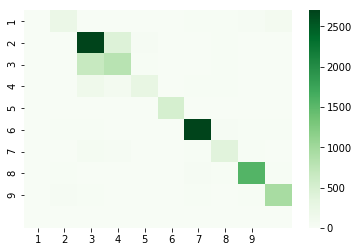

In [35]:
model1 = Sequential()
model1.add(Dense(1500,input_shape=(X_train.shape[1],),activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(750,activation='relu'))
model1.add(Dense(9,activation='softmax'))
model1.compile(optimizer='adam',
              loss='categorical_crossentropy')

model1.fit(X_train.values,OHE_y_train,validation_data=[X_val.values,OHE_y_val],callbacks=[cb],epochs=10)
ann_pred = model1.predict_classes(X_val.values)
from sklearn.metrics import classification_report,log_loss
print(confusion_matrix(y_pred=ann_pred,y_true=y_val))
sns.heatmap(confusion_matrix(y_pred=ann_pred+1,y_true=y_val),cmap='Greens',xticklabels=range(1,10),yticklabels=range(1,10))
print('classification report results:\r\n' + classification_report(y_pred=ann_pred,y_true=y_val))
print('log-loss for classifier: {}'.format(log_loss(y_pred=model1.predict(X_val.values),y_true=y_val)))

In [42]:
print('log-loss for classifier: {}'.format(log_loss(y_pred=np.clip(model1.predict(X_val.values),a_min=0.0001,a_max=0.9999),y_true=y_val)))

log-loss for classifier: 0.4583844790366684


In [43]:
test_pred = np.clip(,a_min=0.001,a_max=0.999)
subm = pd.DataFrame(test_pred)
subm.columns = ['class_'+ str(x) for x in range(1,10)]
subm['id'] = te_ids
subm.to_csv('../subm/ANN_0.4583.csv',index=False)